# BIA Seminar 6
## Image reconstruction advanced

### 3D MRI brain scan registration

Finally, we get to 3D models, which are of particular interest in medical image analysis.

Due to the size of the models and data, we won't be able to train a model within a short tutorial time. Instead, here we assume one has been trained, and demonstrate its use. You can train one very similar to how you trained the 2D models above.

In [2]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

### Model

In [4]:
# our data will be of shape 160 x 192 x 224
vol_shape = (160, 192, 224)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

In [5]:
# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

### Validation data

In [6]:
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]

Load a trained 3D model.

In [7]:
vxm_model.load_weights('brain_3d.h5')

Now let's register.

In [8]:
val_pred = vxm_model.predict(val_input);

1/1 [==============================] - 8s 8s/step


In [9]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

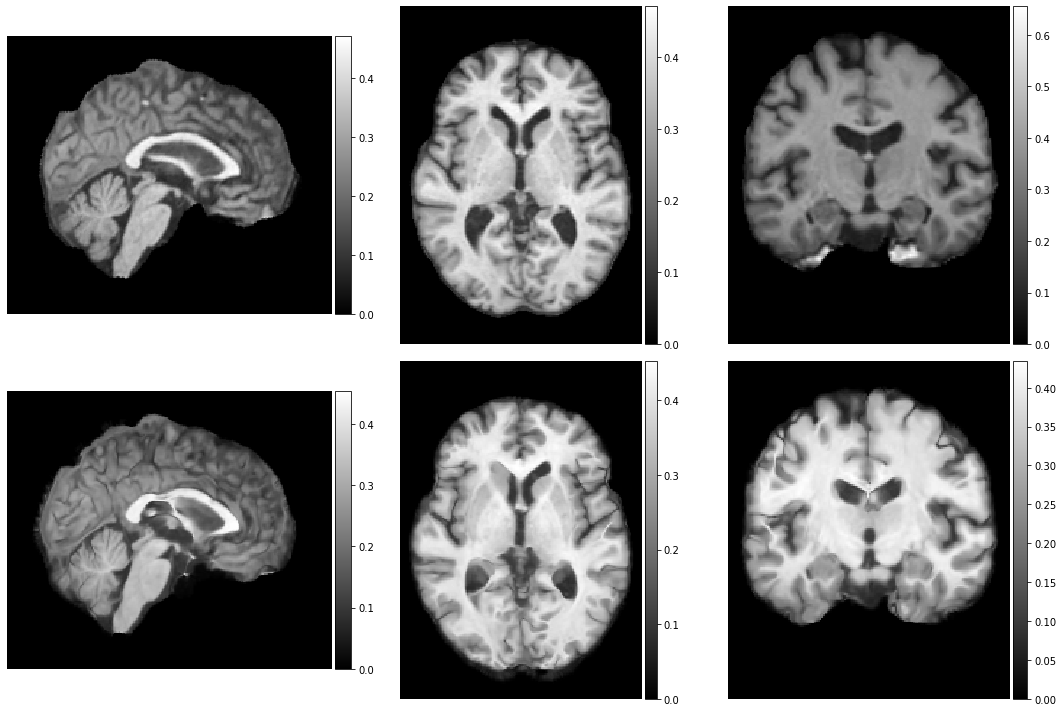

In [10]:
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

Let's look at the segmentations! To do this, we'll need to warp segmentations. 

In [11]:
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

In [12]:
warped_seg = warp_model.predict([seg_volume_1[np.newaxis,...,np.newaxis], pred_warp])

1/1 [==============================] - 0s 319ms/step


We're first going to prepare a colormap.

In [13]:
from pystrum.pytools.plot import jitter
import matplotlib

[ccmap, scrambled_cmap] = jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

Let's visualize the segmentations, and essentially make sure they are not crazy.

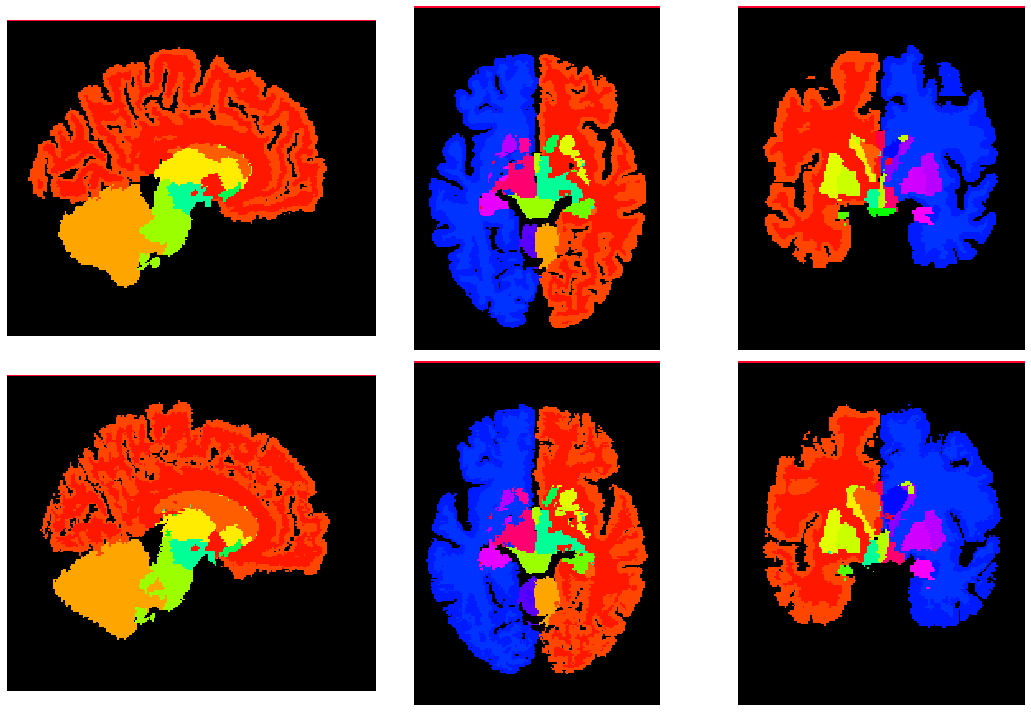

In [14]:
mid_slices_fixed = [np.take(seg_volume_1, vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_fixed + mid_slices_pred
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[2,3]);

## Runtime

An important advantage of learning-based methods is the dramatically lowered runtime.

In [15]:
%timeit vxm_model.predict(val_input)

1/1 [==============================] - 0s 198ms/step
564 ms ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
